In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn import decomposition, manifold

% matplotlib notebook

In [2]:
def compute_distance(x,y):
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    return np.linalg.norm(x-y)

In [96]:
def compute_xcorr(x,y):
    return x.dot(y.T).sum()

In [3]:
def print_percentage(n, t):
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('=' * ((n * 20/t) + 1) , n * 100/t + 1 ))
    sys.stdout.flush()

In [4]:
def norm_feat(feat):
    norms = np.linalg.norm( feat, axis=1)
    feat = (feat.T / norms.T).T
    return feat[ ~np.isnan(feat[:,0]) ]

In [79]:
# def norm_agg_feat(feat):
def norm_agg_feat(x):
    normx = np.linalg.norm(x.sum(axis=0))
    return x / normx

### Sum of Radial Basis Function similarities (RBFsim) effectively estimating kernel density estimate (KDE)

1. For a given feature directory, read in numpy arrays
2. Calculate upper right hand comparisons with RBF kernel function

In [80]:
feature_dir = '/fileserver/nmec-handwriting/localfeatures/nmec_bw_denoised_cc_deNNiam_fiel657_min500/'
#feature_dir = '/fileserver/nmec-handwriting/localfeatures/nmec_bw_cc_deNNiam_fiel657_min500'
#feature_dir = '/fileserver/nmec-handwriting/localfeatures/nmec_bw_crop_cc_deNNiam120_fiel657-120'

files = os.listdir(feature_dir)
files.sort()
files = files[:-1]

C = np.zeros((len(files),len(files)))
feature_map = {}
for i,filei in enumerate(files):
    feati = norm_agg_feat( np.load(feature_dir+"/"+filei) )
    feature_map[filei] = feati
    # for j, filej in enumerate(files):
        # feati = norm_feat( np.load(feature_dir + "/" + filei) )
        # featj = norm_feat( np.load(feature_dir + "/" + filej) )
        # Cij = feati.dot(featj.T)
        # C[i,j] = Cij.max(axis=0).mean()
        # C[i,j] = feati.mean(axis=0).dot(featj.mean(axis=0))
        
        # feati = np.load(feature_dir+"/"+filei).mean(axis=0)
        # featj = np.load(feature_dir+"/"+filej).mean(axis=0)
        # C[i,j] = feati.dot(featj)
        
    print_percentage(i, len(files))

[====================] 100%

In [97]:
metric = []
for i, image in enumerate(feature_map):
    featsi = feature_map[image]
    metricline = [np.array([compute_xcorr(featsi, feature_map[other]) for other in feature_map])]
    metric += metricline
    print_percentage(i, len(feature_map))

metric = np.array(metric)
F = -metric
np.fill_diagonal(F, -sys.maxint)

[====================] 100%

In [ ]:
Csym = np.zeros(C.shape)
Csym[:] = C
for i in xrange(len(files)):
    for j in xrange(len(files)):
        if j > i:
            Csym[j,i] = C[i,j]
F = Csym

In [121]:
#feati.mean(axis=0).dot(featj.mean(axis=0))
F = -metric
np.fill_diagonal(F,-1.0)
print F

[[-1.         -0.98513745 -0.99123242 ..., -0.98274965 -0.98890721
  -0.99360094]
 [-0.98513745 -1.         -0.98661558 ..., -0.97796579 -0.98568049
  -0.98910854]
 [-0.99123242 -0.98661558 -1.         ..., -0.9813538  -0.98945267
  -0.9928922 ]
 ..., 
 [-0.98274965 -0.97796579 -0.9813538  ..., -1.         -0.98524849
  -0.98588588]
 [-0.98890721 -0.98568049 -0.98945267 ..., -0.98524849 -1.         -0.99101115]
 [-0.99360094 -0.98910854 -0.9928922  ..., -0.98588588 -0.99101115 -1.        ]]


In [122]:
soft_correct = 0
hard_correct = 0
total_num = 0

k = 10
g = 8
max_top = 1

for j, i in enumerate(F):
    
    #if not files[j][7:10]=='004':
    #    continue
    
    total_num += 1
    topk = i.argsort()[-k:]
    
    if files[j][:6] in (files[index][:6] for index in topk):
        soft_correct += 1
    
    hardsample = list(files[index][3:6] for index in topk[-max_top:])
    if len(set(hardsample)) == 1 and hardsample[0] == files[j][3:6]:
        print "%s matched %s" % (files[j][3:10], hardsample)
        hard_correct += 1

print "%-30s" % ( "-" * 37 )
print "SOFT CRITERIA: Top %d\t= %f" %(k, (soft_correct + 0.0) / total_num)
print "HARD CRITERIA: Top %d\t= %f" %(max_top, (hard_correct + 0.0) / total_num)

004-002 matched ['004']
004-003 matched ['004']
004-004 matched ['004']
004-005 matched ['004']
004-006 matched ['004']
004-007 matched ['004']
004-008 matched ['004']
-------------------------------------
SOFT CRITERIA: Top 10	= 0.079208
HARD CRITERIA: Top 1	= 0.009901


<IPython.core.display.Javascript object>


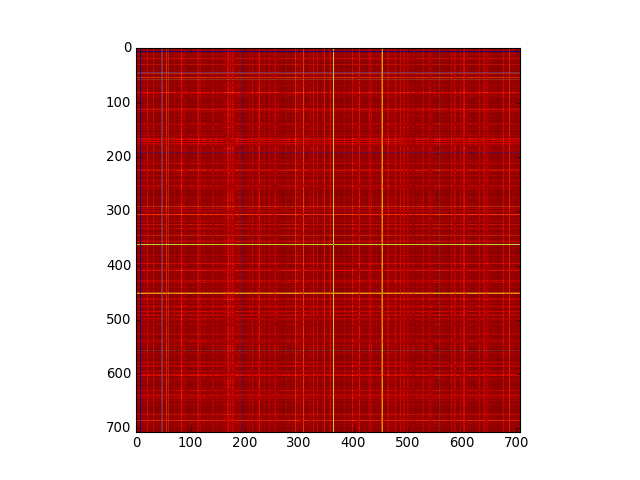

In [130]:
feature_map[filei].dot(feature_map[filei].T).sum()
feature_map['FR-003-001.bin.tif.npy'].dot(feature_map['FR-010-001.bin.tif.npy'].T).sum()
compute_xcorr(feature_map['FR-004-002.bin.tif.npy'],feature_map['FR-004-004.bin.tif.npy'])
plt.imshow(metric)